In [12]:
# import the opencv library
import cv2
import time
import addSrcToPath
import numpy as np
# import os
# import random
import torch
from model.yolov8.semantic import Model
# from dataloader import DataProvider
# import cv2
from utils.image import pad as padImage
from utils.math import MovingAverage
# random.seed(time.time())

purple =  [158, 68, 98]

device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)

purpleTensor = torch.Tensor(purple).to(device, dtype=torch.float)
purpleTensor = purpleTensor.unsqueeze(0).unsqueeze(0).expand(640, 640, 3)
print('purpleTensor:', purpleTensor.shape)

# annotationsDir = os.path.join('.', 'data', 'coco', 'val2017')
# trainDataloader = DataProvider(annotationsDir, 1)

model = torch.load('./Yolov8_bz4_Epochs1_randxy_n-5_dl-50_center_color_epochs-9.pt')
model.eval()
  
# define a video capture object

fps = MovingAverage(20)

vid = cv2.VideoCapture(0)
startTime = time.time()



purpleTensor: torch.Size([640, 640, 3])


In [16]:
def tile(tensor):
  dx, dy, _ = tensor.shape
  ntx = dx//256
  nty = dy//256
  tiles = []
  print(tile)
  for i in range(ntx):
    for j in range(nty):
        print('=>', i*256, (i+1)*256, j*256, (j+1)*256)
        tiles.append(tensor[i*256:(i+1)*256, j*256:(j+1)*256])
  
  return torch.stack(tiles), ntx, nty



In [17]:
import matplotlib.pyplot as plt

In [18]:
ret, frame = vid.read()

In [19]:
image = torch.from_numpy(padImage(frame, symmetric = True))

In [20]:
image.shape

torch.Size([640, 640, 3])

In [21]:
inputStacked, ntx, nty = tile(image)

<function tile at 0x0000020489E5D090>
=> 0 256 0 256
=> 0 256 256 512
=> 256 512 0 256
=> 256 512 256 512


untile
=> 0 256 0 256
=> 0 256 256 512
=> 256 512 0 256
=> 256 512 256 512


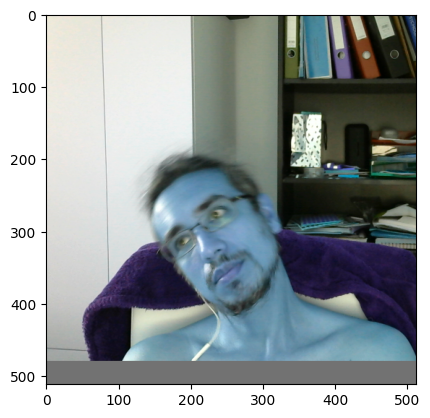

In [15]:
def untile(tensor, ntx, nty):
  print('untile')
  untiled = torch.zeros([256*ntx, 256*nty, 3])

  for i in range(ntx):
    for j in range(nty):
        print('=>', i*256, (i+1)*256, j*256, (j+1)*256)
        untiled[i*256:(i+1)*256, j*256:(j+1)*256, :] = tensor[i*2 + j]

  return untiled

untiledImage = untile(inputStacked, ntx, nty)
plt.imshow(untiledImage.numpy().astype(np.int16))

In [ ]:
import numpy as np

In [ ]:
plt.imshow(untiledImage.numpy().astype(np.int16))

In [ ]:
with torch.no_grad():
  while(True):
    dtA = fps.add(1/(time.time() - startTime + 0.00000000001))
    print('fps =>', dtA)
    startTime = time.time()
        
    # Capture the video frame
    # by frame
    ret, frame = vid.read()

    image = torch.from_numpy(padImage(frame))
    image = image.to(device, dtype=torch.float)
    image = torch.abs(image - purpleTensor)/255
    inputStacked, ntx, nty = tile(image)
    print('image.shape:', image.shape)

    # Display the resulting frame
    
    input = inputStacked.permute(0, 3, 1, 2)
    print('inputStacked.shape:', input.shape)
    pred = model(input)
    pred = pred.squeeze()
    pred = torch.sigmoid(pred)
    
    output = untile(inputStacked, ntx, nty)
    print('output:=>', output.shape)
    output = output.cpu().numpy()
      
    cv2.imshow('frame', output)
    # the 'q' button is set as the
    # quitting button you may use any
    # desired button of your choice
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
    